# Lesson 8 Assignment - Abalone Age Determination

## Author - Connor Higgins

### Background
Age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope. Other measurements, which are easier to obtain, could be used to predict the age. According to the data provider, original data examples with missing values were removed (the majority having the predicted value missing), and the ranges of the continuous values have been scaled (by dividing by 200) for use with machine learning algorithms such as SVMs and ANNs.

The target field is “Rings”. Since the output is continuous the solution can be handled by a Support Vector Regression or it can be changed to a binary Support Vector Classification by assigning examples that are younger than 11 years old to class: ‘0’ and those that are older (class: ‘1’).

Predict the age using the following attributes:
* Sex / nominal / -- / M, F, and I (infant)
* Length / continuous / mm / Longest shell measurement
* Diameter / continuous / mm / perpendicular to length
* Height / continuous / mm / with meat in shell
* Whole weight / continuous / grams / whole abalone
* Shucked weight / continuous / grams / weight of meat
* Viscera weight / continuous / grams / gut weight (after bleeding)
* Shell weight / continuous / grams / after being dried

See [UCI's Abalone Data set](https://archive.ics.uci.edu/ml/datasets/abalone) for more information.

## Tasks
Use the provided abalone.csv file, build an experiment using support vector machine classifier and regression. Complete the following tasks and answer the questions:

1. Convert the continuous output value from continuous to binary (0,1) and build an SVC
2. Using your best guess for hyperparameters and kernel, what is the percentage of correctly classified results?
3. Test different kernels and hyperparameters or consider using `sklearn.model_selection.GridSearchCV`. Which kernel performed best with what settings?
4. Show recall, precision and f-measure for the best model
5. Using the original data, with rings as a continuous variable, create an SVR model
6. Report on the predicted variance and the mean squared error

### Data Preparation

In [1]:
# Data set contains 4177 rows and 9 columns.
URL = "https://library.startlearninglabs.uw.edu/DATASCI420/Datasets/abalone.csv"

In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Reading in abalone.csv as dataframe df
df = pd.read_csv(URL)
df.head()

,Sex,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [4]:
# Obtaining summary statistics
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
Sex               4177 non-null object
Length            4177 non-null float64
Diameter          4177 non-null float64
Height            4177 non-null float64
Whole Weight      4177 non-null float64
Shucked Weight    4177 non-null float64
Viscera Weight    4177 non-null float64
Shell Weight      4177 non-null float64
Rings             4177 non-null int64
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB
None


,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [5]:
# Converting Sex feature from categorical to one-hot-encoded
print('Original Feature')
print(df['Sex'].value_counts())

df['Sex_M'] = 0
df.loc[df['Sex'] == 'M', 'Sex_M'] =  1
males = df['Sex_M'].sum()
print(f"\nTotal Sex_M: {males} (New Feature)")

df['Sex_F'] = 0
df.loc[df['Sex'] == 'F', 'Sex_F'] =  1
females = df['Sex_F'].sum()
print(f"Total Sex_F: {females} (New Feature)")

infants = len(df) - males - females
print(f'Total Infants: {infants}')

df.drop('Sex', axis=1, inplace=True)

Original Feature
M    1528
I    1342
F    1307
Name: Sex, dtype: int64

Total Sex_M: 1528 (New Feature)
Total Sex_F: 1307 (New Feature)
Total Infants: 1342


In [6]:
# Converting Rings target from continuous to binary (0,1)
# < 11 years old: Class 0; >= 11 years old: Class 1
bins = pd.IntervalIndex.from_tuples([(0, 10), (11, 29)], closed='both')
df['Rings Class'] = pd.cut(df['Rings'], bins)

classes = {pd.Interval(0, 10, closed='both'): '0',
           pd.Interval(11, 29, closed='both'): '1'}
df['Rings Class'].replace(classes, inplace=True)
df['Rings Class'] = df['Rings Class'].astype(int)

df['Rings Class'].value_counts()

0    2730
1    1447
Name: Rings Class, dtype: int64

In [7]:
# Separating features from targets Rings and Rings Class
X = df.drop(['Rings', 'Rings Class'], axis=1)
targets = df[['Rings', 'Rings Class']]
print(f'X shape: {X.shape}')
print(f'targets shape: {targets.shape}')

X shape: (4177, 9)
targets shape: (4177, 2)


In [8]:
# Splitting data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, targets_train, targets_test = \
    train_test_split(X, targets, test_size=0.2, random_state=42)
print(f'X_train shape: {X_train.shape} '
      f'| X_test shape: {X_test.shape}')
print(f'targets_train shape: {targets_train.shape} '
      f'| targets_test shape: {targets_test.shape}')

X_train shape: (3341, 9) | X_test shape: (836, 9)
targets_train shape: (3341, 2) | targets_test shape: (836, 2)


In [9]:
# Splitting targets into y_reg (Rings) and y_clf (Rings Class) 
y_reg_train = targets_train['Rings']
y_reg_test = targets_test['Rings']
y_cls_train = targets_train['Rings Class']
y_cls_test = targets_test['Rings Class']
print(f'y_reg_train shape: {y_reg_train.shape} '
      f'| y_reg_test shape: {y_reg_test.shape}')
print(f'y_cls_train shape: {y_cls_train.shape} '
      f'| y_cls_test shape: {y_cls_test.shape}')

y_reg_train shape: (3341,) | y_reg_test shape: (836,)
y_cls_train shape: (3341,) | y_cls_test shape: (836,)


## Modeling: Classification

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def conf_mat_class_report(y_test, y_pred, label):
    """Returns confusion matrix heatmap and classification report for given y_test and y_pred"""
    acc_score = accuracy_score(y_test, y_pred)
    conf_mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Greens')
    plt.xlabel('Predicted')
    plt.ylabel('Actual', rotation=0)
    plt.xticks([0.5,1.5], ['Positive', 'Negative'])
    plt.yticks([0.5,1.5], ['Positive', 'Negative'], rotation=0)
    plt.title(f'Confusion matrix for {label}\n with overall accuracy: {acc_score*100:.3f}%')
    plt.show()
    return print(classification_report(y_test, y_pred, digits=3))

### Initial SVC model

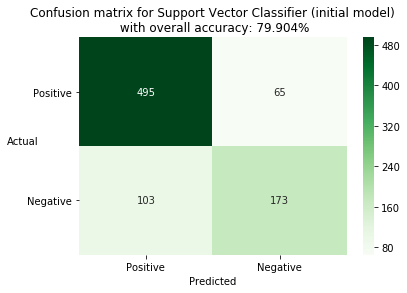

              precision    recall  f1-score   support

           0      0.828     0.884     0.855       560
           1      0.727     0.627     0.673       276

   micro avg      0.799     0.799     0.799       836
   macro avg      0.777     0.755     0.764       836
weighted avg      0.794     0.799     0.795       836



In [11]:
# Creating initial SVC model using best estimate hyperparameters
from sklearn.svm import SVC

gamma_ci ='auto'
kernel_ci = 'linear'
cost_ci = 40

clf_i = SVC(gamma=gamma_ci, kernel=kernel_ci, C=cost_ci).fit(X_train, y_cls_train)
y_cls_pred_i = clf_i.predict(X_test)

conf_mat_class_report(y_cls_test, y_cls_pred_i, 'Support Vector Classifier (initial model)')

#### Figure 1.  Results of initial SVC model using best guess for hyperparameters and kernel
An initial SVC model was created using a linear kernal, a cost of 40, and gamma set to 'auto'. Overall, the model performed reasonably well with an overall accuracy score of 79.9%, a precision score of 79.4%, a recall score of 79.9%, and a f1-score of 79.5%.

### SVC model using GridSearchCV

In [12]:
# Creating final SVC model using GridSearchCV
from sklearn.model_selection import GridSearchCV

# Original param_grid:
#svc_param_grid = {'C': [i for i in range(1, 10)] + [i for i in range(10, 110, 10)],
#                  'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#                  'gamma': ['auto' if i==11 else i for i in range(0, 12)]}

# Reduced param_grid for notebook reporting
svc_param_grid = {'C': [i for i in range(10, 110, 10)],
                  'kernel': ['linear', 'rbf'],
                  'gamma': ['auto' if i==5 else i for i in range(0, 6)]}

svc_gridsrch_cv = GridSearchCV(estimator=SVC(), param_grid=svc_param_grid,
                               cv=5, verbose=2, n_jobs=-1)
svc_gridsrch_cv.fit(X_train, y_cls_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'kernel': ['linear', 'rbf'], 'gamma': [0, 1, 2, 3, 4, 'auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

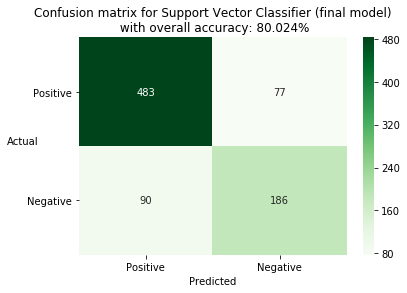

              precision    recall  f1-score   support

           0      0.843     0.863     0.853       560
           1      0.707     0.674     0.690       276

   micro avg      0.800     0.800     0.800       836
   macro avg      0.775     0.768     0.771       836
weighted avg      0.798     0.800     0.799       836

Chosen Hyperparameters: {'C': 70, 'gamma': 1, 'kernel': 'rbf'}


In [13]:
# Obtaining final SVC model results
svc_params = svc_gridsrch_cv.best_params_

gamma_cf = svc_params['gamma']
kernel_cf = svc_params['kernel']
cost_cf = svc_params['C']

clf_f = SVC(gamma=gamma_cf, kernel=kernel_cf, C=cost_cf).fit(X_train, y_cls_train)
y_cls_pred_f = clf_f.predict(X_test)

conf_mat_class_report(y_cls_test, y_cls_pred_f, 'Support Vector Classifier (final model)')
print(f'Chosen Hyperparameters: {svc_params}')

#### Figure 2.  Results of final SVC model using hyperparameters selected by GridSearchCV
To improve upon the initial SVC model, sklearn's GridSearchCV was utilized to effectively obtain the best performing hyperparameters. The final SVC model used a rbf kernal, and cost of 70, and gamma set to 1. Very modest improvement was shown across a number of metrics, including accuracy (80.0% v. 79.9%), precision (79.8% v. 79.4%), recall (80.0% v. 79.9%), and f1 (79.9% v. 79.5%).

## Modeling: Regression

In [14]:
sns.set(style='whitegrid')

def PartialRegressionMultiPlot(y_test, y_pred, label):
    """
    Returns partial regression plots for 4 features within X_test,
    chosen for their high correlation to the Rings target
    """
    X_sw = X_test['Shell Weight'].values
    plt.figure(figsize=(12,8))
    plt.suptitle(f'Partial Regression plots for {label}', y=0.95)
    plt.scatter(X_sw, y_test,
                s=8, alpha=0.6, color='blue', label='Actual')
    plt.scatter(X_sw, y_pred,
                s=8, alpha=0.6, color='red', label='Predicted')
    for i in range(len(X_sw)): # Drawing lines between actual v. pred
        plt.plot([X_sw[i], X_sw[i]],
                 [y_test[i], y_pred[i]],
                 c="k", linewidth=0.15)
    plt.xlabel('Shell Weight')
    plt.ylabel('Rings')
    plt.title('Shell Weight v. Rings', fontsize=13)
    plt.ylim(-5, 25)
    plt.legend()
    plt.show()
    plt.figure(figsize=(12,5))
    subs = [131, 132, 133]
    feats = ['Length', 'Height', 'Diameter']
    for i in range(3):
        ax = plt.subplot(subs[i])
        plt.scatter(X_test[feats[i]], y_test,
                    s=5, alpha=0.6, color='blue')
        plt.scatter(X_test[feats[i]], y_pred,
                    s=5, alpha=0.6, color='red')
        plt.title(feats[i] + ' v. Rings')
        plt.ylim(-5, 25)
        plt.xlabel(feats[i])
        if i == 0:
            plt.ylabel('Rings')
    return plt.show()

### Initial SVR model

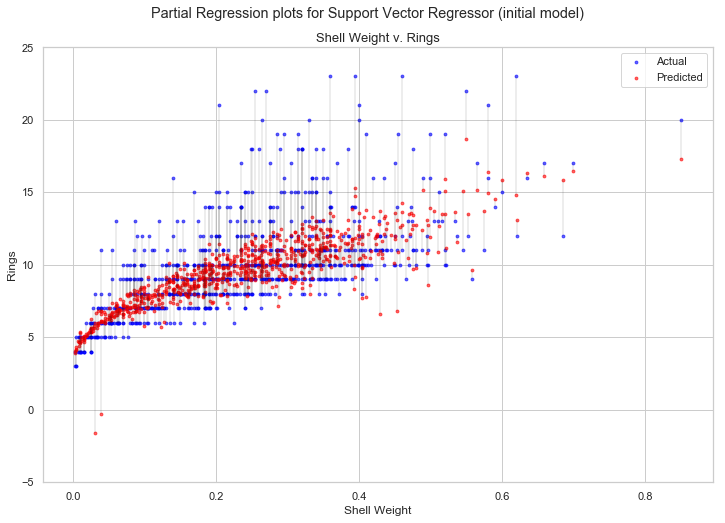

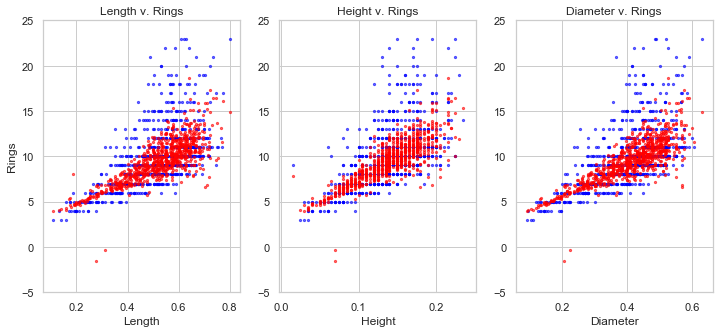

---Initial SVR Results---
R-Squared: 0.531
Mean Squared Error: 5.076


In [15]:
# Creating SVR model using best estimate hyperparameters (same as SVC initial)
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

gamma_ri = 'auto'
kernel_ri = 'linear'
cost_ri = 40

reg_i = SVR(gamma=gamma_ri, kernel=kernel_ri, C=cost_ri).fit(X_train, y_reg_train)
y_reg_i_pred = reg_i.predict(X_test)

label = 'Support Vector Regressor (initial model)'
PartialRegressionMultiPlot(y_reg_test.values, y_reg_i_pred, label)
print('---Initial SVR Results---')
r2_i = reg_i.score(X_test, y_reg_test)
print(f'R-Squared: {r2_i:.3f}')
mse_i = mean_squared_error(y_reg_test, y_reg_i_pred)
print(f'Mean Squared Error: {mse_i:.3f}')

#### Figure 3.  Results of initial SVR model using best guess for hyperparameters and kernel
An initial SVR model was created using the same estimated hyperparameters from the initial SVC model: a linear kernal, a cost of 40, and gamma set to 'auto'. To visualize the model's performance, partial regression plots for four of the most correlative features were created. Overall, the initial model achieved a modest R-Squared of 0.531 and MSE of 5.076.

### SVR model using GridSearchCV

In [16]:
# Creating final SVR model using GridSearchCV

# Original param_grid:
#svr_param_grid = {'C': [i for i in range(10, 110, 10)],
#                  'kernel': ['linear', 'rbf', 'poly'],
#                  'gamma': ['auto' if i==11 else i for i in range(0, 12)]}

# Reduced param_grid for notebook reporting
svr_param_grid = {'C': [i for i in range(10, 60, 10)],
                  'kernel': ['linear', 'rbf'],
                  'gamma': ['auto' if i==5 else i for i in range(0, 6)]}

svr_gridsrch_cv = GridSearchCV(estimator=SVR(), param_grid=svr_param_grid,
                               cv=5, verbose=2, n_jobs=-1)
svr_gridsrch_cv.fit(X_train, y_reg_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [10, 20, 30, 40, 50], 'kernel': ['linear', 'rbf'], 'gamma': [0, 1, 2, 3, 4, 'auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

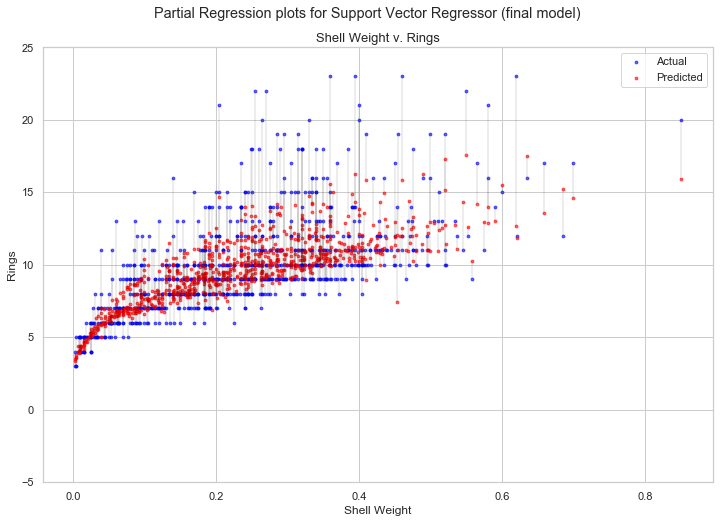

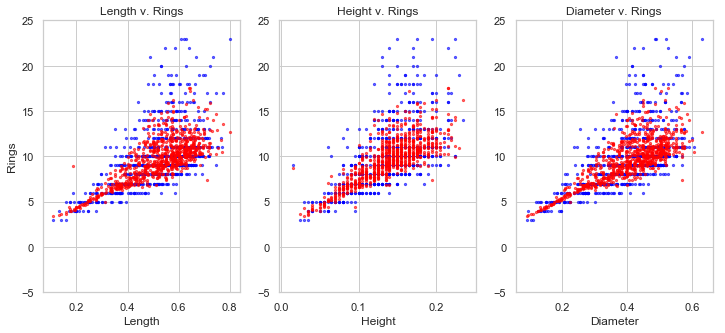

---Final SVR Results---
R-Squared: 0.570 (Initial: 0.531)
Mean Squared Error: 4.658 (Initial: 5.076)
Chosen Hyperparameters: {'C': 20, 'gamma': 2, 'kernel': 'rbf'}


In [17]:
# Obtaining final SVC model results
svr_params = svr_gridsrch_cv.best_params_

gamma_rf = svr_params['gamma']
kernel_rf = svr_params['kernel']
cost_rf = svr_params['C']

reg_f = SVR(gamma=gamma_rf, kernel=kernel_rf, C=cost_rf).fit(X_train, y_reg_train)
y_reg_f_pred = reg_f.predict(X_test)

label = 'Support Vector Regressor (final model)'
PartialRegressionMultiPlot(y_reg_test.values, y_reg_f_pred, label)
print('---Final SVR Results---')
r2_f = reg_f.score(X_test, y_reg_test)
print(f'R-Squared: {r2_f:.3f} (Initial: {r2_i:.3f})')
mse_f = mean_squared_error(y_reg_test, y_reg_f_pred)
print(f'Mean Squared Error: {mse_f:.3f} (Initial: {mse_i:.3f})')
print(f'Chosen Hyperparameters: {svr_params}')

#### Figure 4. Results of final SVR model using hyperparameters selected by GridSearchCV
A final SVR model was created using hyperparameters selected by sklearn's GridSearchCV. As with the final SVC model, an rbf kernal was chosen, though with different cost (20 v. 70) and gamma (2 v. 1) values. There was a reasonable increase in the overall performance, with an R-Squared of 0.570 (v. 0.531) and MSE of 4.658 (v. 5.076). Partial regression plots for Shell Weight, Length, Height, and Diameter features visually demonstrate a better fit with fewer outliers.